In [1]:
# We will start by creating simple functions to classify the input question and handle the greeting and search questions.
def classify(question: str) -> str:
    return "greeting" if question.startswith("Hello") else "search"


def classify_input_node(state):
    question = state.get("question", "").strip()
    classification = classify(question)  # Assume a function that classifies the input
    return {"classification": classification}


def handle_greeting_node(state):
    return {"response": "Hello! How can I help you today?"}


def handle_search_node(state):
    question = state.get("question", "").strip()
    search_result = f"Search result for '{question}'"
    return {"response": search_result}

In [2]:
from langgraph.graph import StateGraph, END

from typing import TypedDict, Optional


class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None


workflow = StateGraph(GraphState)
workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
workflow.add_node("handle_search", handle_search_node)


def decide_next_node(state):
    return (
        "handle_greeting"
        if state.get("classification") == "greeting"
        else "handle_search"
    )


workflow.add_conditional_edges(
    "classify_input",
    decide_next_node,
    {"handle_greeting": "handle_greeting", "handle_search": "handle_search"},
)

workflow.set_entry_point("classify_input")
workflow.add_edge("handle_greeting", END)
workflow.add_edge("handle_search", END)

app = workflow.compile()

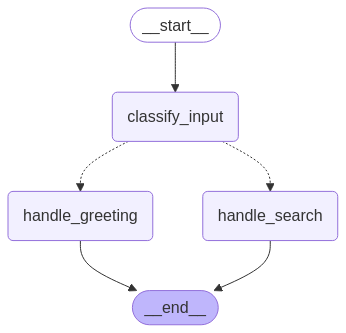

In [3]:
# Display the graph
try:
    from IPython.display import Image, display

    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
from opik.integrations.langchain import OpikTracer

tracer = OpikTracer(graph=app.get_graph(xray=True))
inputs = {"question": "Hello, how are you?"}
result = app.invoke(inputs, config={"callbacks": [tracer]})
print(result)

OPIK: Started logging traces to the "Default Project" project at http://trainingvm:5173/api/v1/session/redirect/projects/?trace_id=0195c567-3e91-7786-8f91-9ed89b270432&path=aHR0cDovL3RyYWluaW5ndm06NTE3My9hcGkv.


{'question': 'Hello, how are you?', 'classification': 'greeting', 'response': 'Hello! How can I help you today?'}
